In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


# this is the size of our encoded representations
original_dim = 50
encoding_dim = 64

input_img = Input(shape=(original_dim, original_dim, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# (5, 5, 8)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

### Original
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
###

### Edited
x = UpSampling2D((2,2))(encoded)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2,2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2,2))(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


In [2]:
# from keras.datasets import mnist
import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

In [3]:
from time import time

def load_data():
    start = time()
    print('Getting labels')
    labels = np.loadtxt('data/labels_3.csv', delimiter=',', dtype=np.float32)
    labels = np.minimum(1.0, labels)
    labels.shape = (-1,1)

    print('Getting features')
    rgb = np.loadtxt('data/rgbdata50_3.csv', delimiter=',', dtype=np.float32)
#     rgb.shape = (-1, 64, 64)
    rgb.shape = (-1, 3, 50, 50)
    rgb = np.mean(rgb, axis=1)
    print('Job completed in: {} seconds'.format(time()-start))
    return rgb, labels

rgb, labels = load_data()
nb_classes = 1
print('rgb shape', rgb.shape)
print('labels shape', labels.shape)

Getting labels
Getting features
Job completed in: 162.58636212348938 seconds
rgb shape (15000, 50, 50)
labels shape (15000, 1)


In [4]:
def divide_data(rgb, labels, data_size=None, train_ratio=0.9):
    '''Randomly select given number of data and divide into training set and test set'''
    data_size_max = labels.shape[0]
    data_size = data_size_max if data_size is None else data_size
    train_size = int(np.floor(train_ratio * data_size))

    mask = list(range(data_size_max))
    mask = np.random.choice(mask, data_size, replace=False)
    rgb = rgb[mask]/255
    labels = np.minimum(labels[mask], 1.0)
    x_train = rgb[:train_size]
    y_train = labels[:train_size]
    x_test = rgb[train_size:]
    y_test = labels[train_size:]

    return (x_train, y_train), (x_test, y_test)

# CHOICE 2: SINGLE CLASS
nb_classes = 1
label_md = np.copy(labels)
label_md.shape = (-1,nb_classes)

(x_train, y_train), (x_test, y_test) = divide_data(rgb, label_md, 
#                                                    data_size=1000, 
                                                   train_ratio=6/7) # 10/11 this ratio allows train = 10*test
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)


x_train shape: (12857, 50, 50)
y_train shape: (12857, 1)


In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(12857, 50, 50)
(2143, 50, 50)


In [8]:
x_train.shape = (len(x_train), original_dim, original_dim, 1)
x_test.shape = (len(x_test), original_dim, original_dim, 1)

In [9]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
               callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

ValueError: Error when checking target: expected conv2d_2 to have shape (None, 1, 50, 2) but got array with shape (12857, 50, 50, 1)

In [42]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

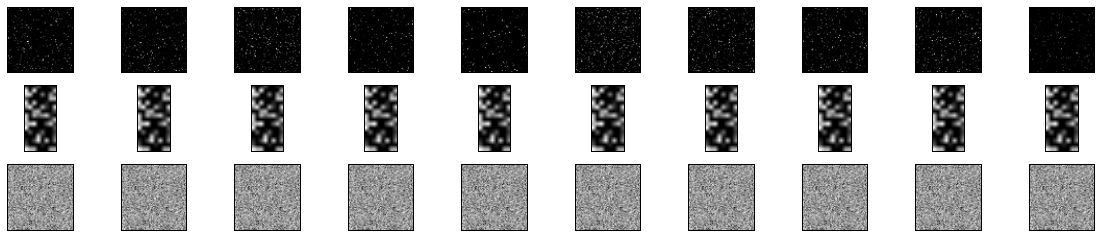

In [44]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(original_dim, original_dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i].reshape(original_dim, original_dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

ValueError: Error when checking target: expected conv2d_63 to have shape (None, 1, 28, 4) but got array with shape (60000, 28, 28, 1)

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
print(keras.__version__)

2.0.4
